# Objective: Training and fine-tuning DETR model

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.1.1 False


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
    return probas_to_keep, bboxes_scaled

In [4]:
# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [16]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [65]:
dataDir = 'data'
dataType = 'training_imgs'
annFile = 'data/annotations/custom_train.json'

In [56]:
# initialize COCO api for instance annotations
coco = COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms = [cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Categories: ['UG', 'OH']
Super-categories: {''}


## Displaying random OH (overhead) training image as well as its bounding box

In [57]:
catIds = coco.getCatIds(catNms=['OH']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°770
Image name: data/training_imgs/OH2_0_90.jpg


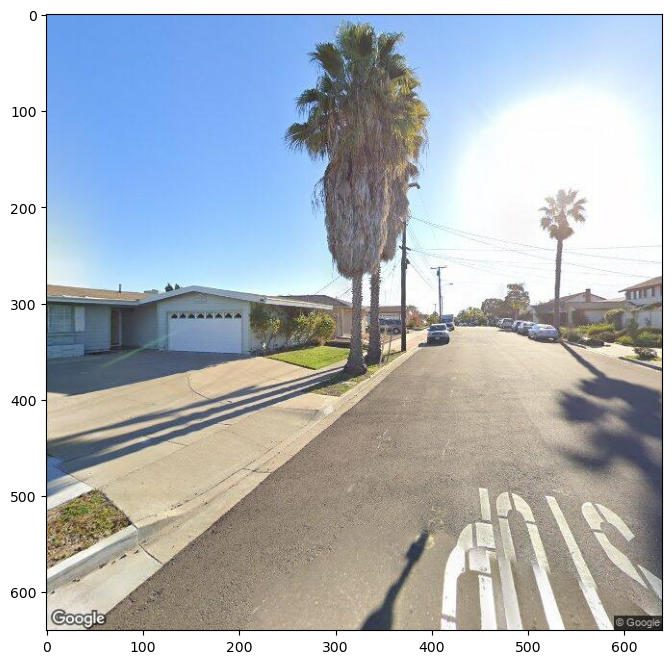

In [58]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [59]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

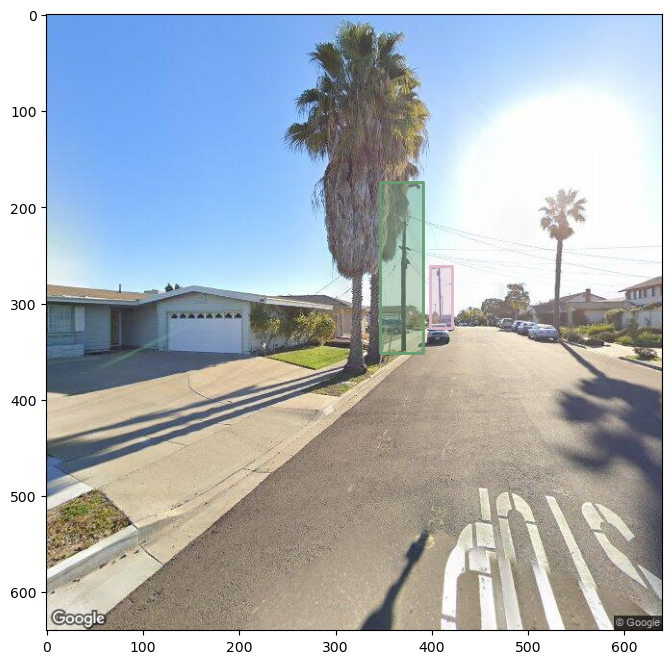

In [60]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

# WIP Below

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [36]:
first_class_index = 1

In [37]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

    num_classes = 1

    finetuned_classes = [
        'balloon',
    ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

    num_classes = 2

    finetuned_classes = [
        'N/A', 'balloon',
    ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 2
Fine-tuned classes: ['N/A', 'balloon']


In [27]:
%cd /content/detr/

/content/detr


# WIP ABOVE

**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

In [55]:
num_classes =3

In [58]:
!python detr/main.py \
  --dataset_file "custom" \
  --coco_path "data" \
  --output_dir "outputs" \
  --resume "detr/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 15 \
  --device cuda \
  --resume 'outputs/checkpoint.pth'

Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: has uncommited changes, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=15, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=3, dataset_file='custom', coco_path='data', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='outputs/checkpoint.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 

In [33]:
!python detr/main.py \
  --dataset_file "custom" \
  --coco_path "data" \
  --output_dir "outputs" \
  --resume "detr/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10 \
  --device cuda

Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: has uncommited changes, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=3, dataset_file='custom', coco_path='data', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr/detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The p

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [38]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

In [39]:
log_directory

[PosixPath('outputs')]

In [40]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PurePath

In [41]:
def plot_logs_new(logs, fields=('class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    '''
    Function to plot specific fields from training log(s). Plots both training and test results.

    :: Inputs - logs = list containing Path objects, each pointing to individual dir with a log file
              - fields = which results to plot from each log file - plots both training and test for each field.
              - ewm_col = optional, which column to use as the exponential weighted smoothing of the plots
              - log_name = optional, name of log file if different than default 'log.txt'.

    :: Outputs - matplotlib plots of results in fields, color coded for each log file.
               - solid lines are training results, dashed lines are test results.

    '''
    func_name = "plot_utils.py::plot_logs"

    # verify logs is a list of Paths (list[Paths]) or single Pathlib object Path,
    # convert single Path to list to avoid 'not iterable' error

    if not isinstance(logs, list):
        if isinstance(logs, PurePath):
            logs = [logs]
            print(f"{func_name} info: logs param expects a list argument, converted to list[Path].")
        else:
            raise ValueError(f"{func_name} - invalid argument for logs parameter.\n \
            Expect list[Path] or single Path obj, received {type(logs)}")

    # Quality checks - verify valid dir(s), that every item in list is Path object, and that log_name exists in each dir
    for i, dir in enumerate(logs):
        if not isinstance(dir, PurePath):
            raise ValueError(f"{func_name} - non-Path object in logs argument of {type(dir)}: \n{dir}")
        if not dir.exists():
            raise ValueError(f"{func_name} - invalid directory in logs argument:\n{dir}")
        # verify log_name exists
        fn = Path(dir / log_name)
        if not fn.exists():
            print(f"-> missing {log_name}.  Have you gotten to Epoch 1 in training?")
            print(f"--> full path of missing log file: {fn}")
            return

    # load log file(s) and plot
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            if field == 'mAP':
                coco_eval = pd.DataFrame(
                    np.stack(df.test_coco_eval_bbox.dropna().values)[:, 1]
                ).ewm(com=ewm_col).mean()
                axs[j].plot(coco_eval, c=color)
            else:
                dfs[0].plot(#.interpolate().ewm(com=ewm_col).mean().plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])
        ax.set_title(field)

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

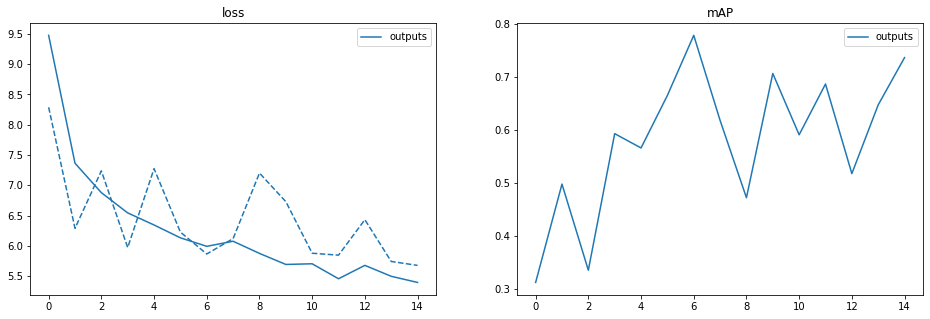

In [59]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs_new(log_directory,
          fields_of_interest)

In [16]:
# fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

# dfs[0].plot(#interpolate().ewm(com=0).mean()
#                     y=[f'train_loss', f'test_loss'],
#                     ax=axs[0],#j
#                     color=[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]*2,#[0] * 2,
#                     style=['-', '--'])

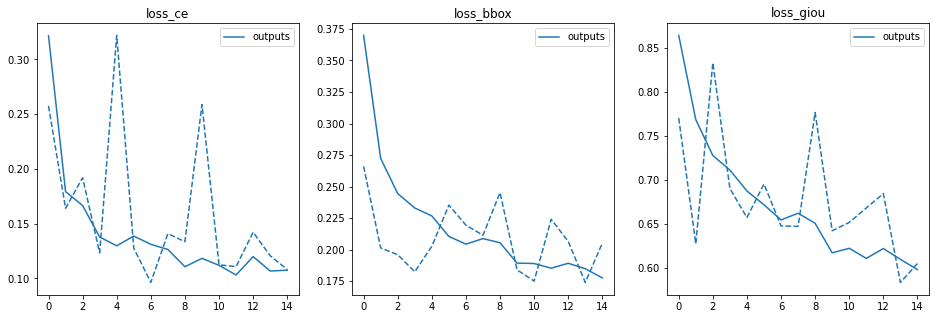

In [60]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs_new(log_directory,
          fields_of_interest)

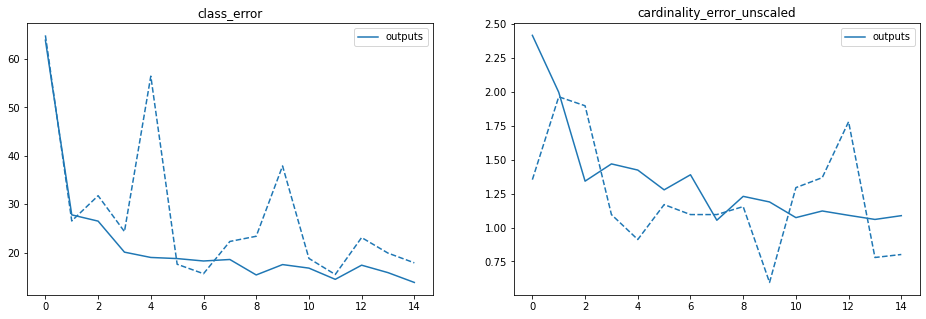

In [61]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs_new(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [62]:
finetuned_classes = [
        'N/A', 'Box', 'Pole',
    ]

In [63]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /tmp/xdg-cache/torch/hub/facebookresearch_detr_main
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Boilerplate functions to display fine-tuned results

In [53]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [81]:
def run_worflow(my_image, my_model):
    
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.8, 0.6]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        plot_finetuned_results(my_image,probas_to_keep, bboxes_scaled)


### With a training image

In [83]:
from PIL import Image

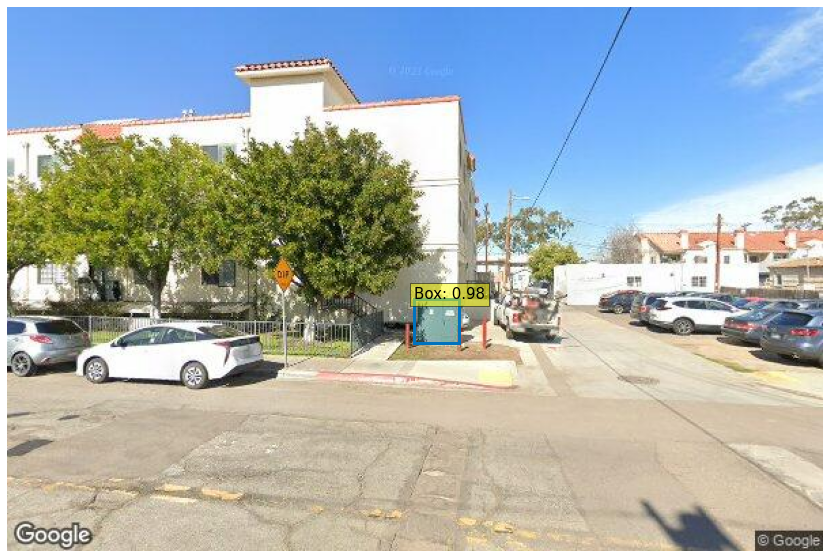

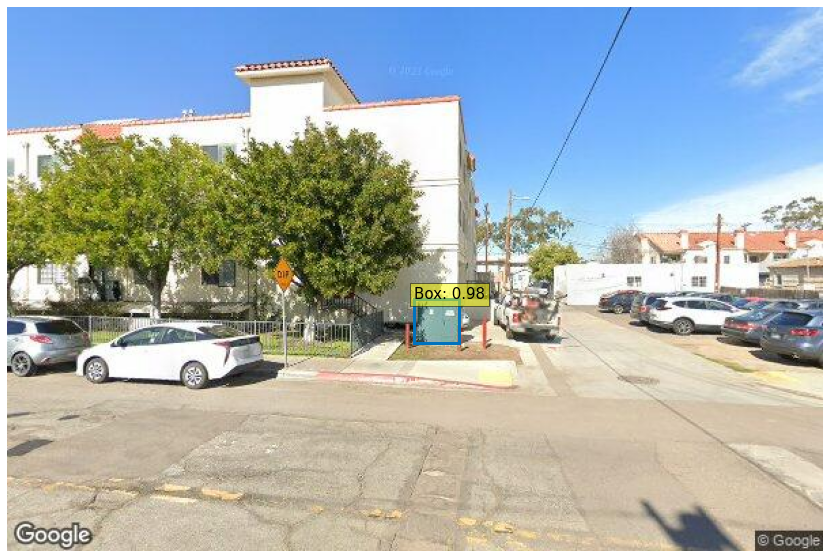

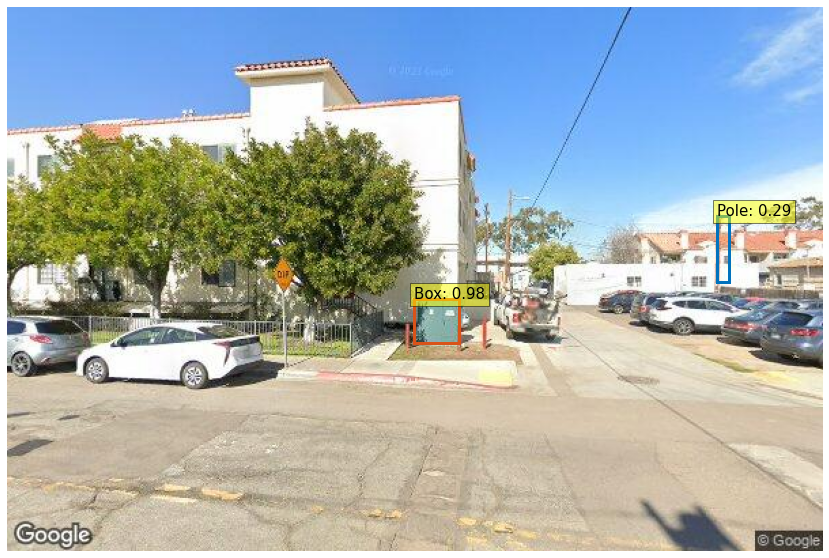

In [84]:

#P729609_5_1.png
#D2547878069_13_50.jpg
#c7_zoomzoom_loc7.jpg
#img_name = 'data/josh_images/D2665177990_5_2.png'#'/content/data/custom/train2017/145053828_e0e748717c_b.jpg'

#kevin_images_D158798_1_2.jpg
img_name = 'data/training_imgs/UG_4_v3_f90.jpg'#'data/c7_zoomzoom_loc7.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

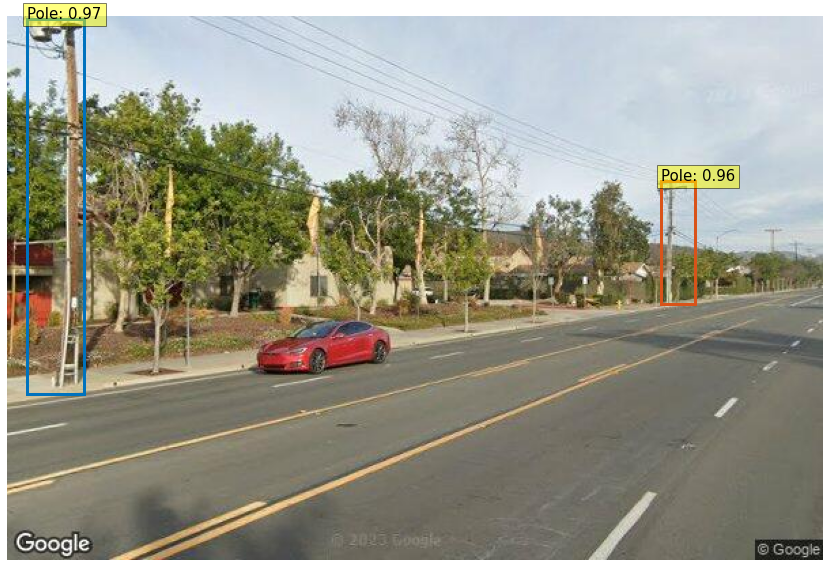

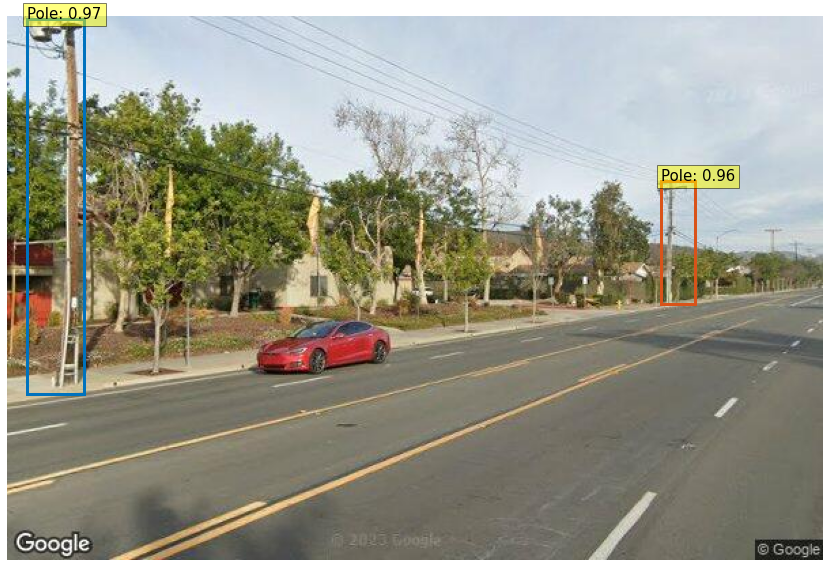

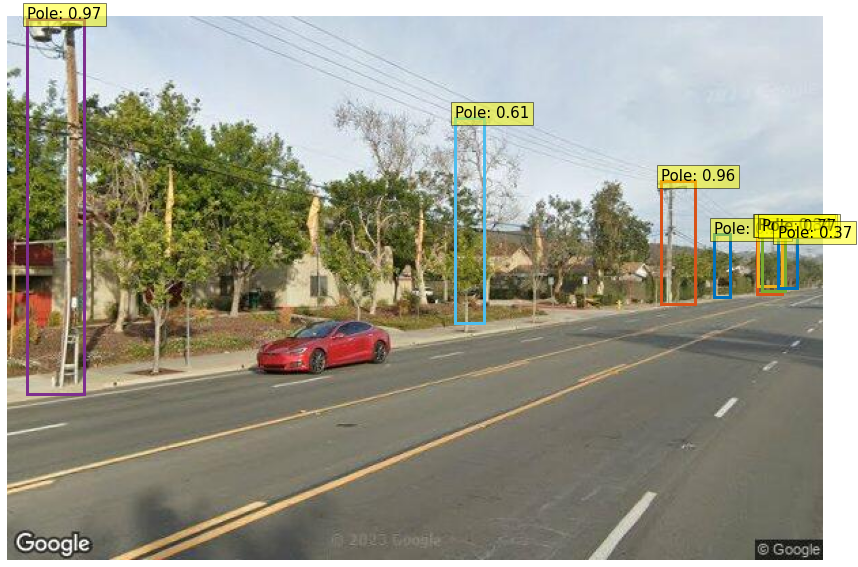

In [90]:
img_name = 'data/val_imgs/P716863_qwocD3mzJDcollQT0ex3Ag_60.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)